### Code to embed 100,000 FSPS model spectra with zcontinuous=1 and diverse SFHs and look for meaningful dimensions in the embeddings

Authored by OGT 17-06-21

In [1]:
# imports and plotting setup
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from astroML.plotting import setup_text_plots
import h5py

from megaman.geometry import Geometry
from megaman.embedding import SpectralEmbedding
from scipy.io import mmwrite
from scipy.sparse.csgraph import connected_components
from sklearn.metrics.pairwise import euclidean_distances

np.set_printoptions(suppress=True)
setup_text_plots(fontsize=16)
mpl.rc('xtick', labelsize=14)
mpl.rc('ytick', labelsize=14)
mpl.rc('font', size=16, family='serif', style='normal', variant='normal', stretch='normal', weight='bold')
mpl.rc('legend', labelspacing=0.1, handlelength=2, fontsize=10)
mpl.rc('axes', labelweight='black')

In [2]:
# load data

f = h5py.File('../data/1e5_spectra_diverseSFH_17-02-07.hdf5','r')
spectra = f['spectra'][:]
wave = f['wave'][:]
taus = f['taus'][:]
mean_ages = f['mean_ages'][:]
zs = f['zs'][:]
dusts = f['dusts'][:]
sdss_mags = f['sdss_mags'][:]
fbursts = f['fbursts'][:]
tbursts = f['tbursts'][:]
sf_begins = f['sf_begins'][:]
f.close()

In [73]:
# copy some plotting code to make life easier

def make_cc_plot(embed, color, label, dims=[[0,1],[2,1]], axlim=None):
    # axlim is a list of [min,max] for dim0, dim2, dim1 (left x, right x, mutual y axes)
    fig, ax = plt.subplots(1,2, figsize=(10,4))
    
    a = ax[0].scatter(embed[:,dims[0][0]], embed[:,dims[0][1]], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(a, ax=ax[0], label=label)
    ax[0].set_xlabel('dim'+str(dims[0][0]))
    ax[0].set_ylabel('dim'+str(dims[0][1]))

    b = ax[1].scatter(embed[:,dims[1][0]], embed[:,dims[1][1]], c=color, lw=0, s=5, cmap='viridis')
    plt.colorbar(b, ax=ax[1], label=label)
    ax[1].set_xlabel('dim'+str(dims[1][0]))
    ax[1].set_ylabel('dim'+str(dims[1][1]))
    
    if axlim is not None:
        ax[0].set_xlim(axlim[0])
        ax[0].set_ylim(axlim[2])
        ax[1].set_xlim(axlim[1])
        ax[1].set_ylim(axlim[2])
        
    plt.tight_layout()
    return fig, ax

In [35]:
# do a dense distance matrix for a 10,000 spectrum subset of the data to determine dimensionality, radius
# code taken from NvsR.ipynb

distmatrix = euclidean_distances(spectra[:10000,:])

ns = []
rs = np.logspace(-1.5,1.5,300)

for r in rs:
    test = distmatrix <= r
    neighbors = np.sum(test, axis=0) 
    ns.append(np.mean(neighbors) - 1.)  # account for one 0 per row (erronious neighbor)

In [36]:
logr = np.log10(rs)
logn = np.log10(ns)
wh = logr < 0.2

In [37]:
# fit a quick line to linear part -- dimensionality
from scipy.optimize import curve_fit

def f(x, A, B):
    return A*x + B

A, B = curve_fit(f, logr[wh], logn[wh])[0]
print A

3.03457661725


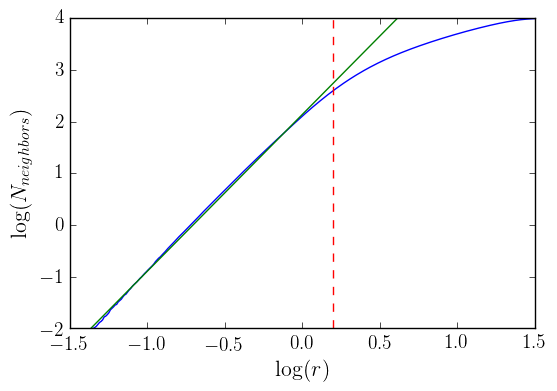

In [39]:
plt.figure();
plt.plot(logr, logn);
plt.xlabel(r'$\log(r)$');
plt.ylabel(r'$\log(N_{neighbors})$');
plt.plot(logr, f(logr, A, B));
plt.plot([0.2,0.2],[-2,4],'--');
plt.ylim(-2,4);

#### OK, want to choose log(r) such that log(n) is roughly 3, because we need 30 neighbors at the cutoff in the full sample (10x larger). And we want to choose a slightly larger log(r) because the kernel width is r/3. So let's choose the radius where we have 9 neighbors.

Update -- this radius was too small; no information captured in embedding. Trying again with just the 10,000 spectrum subsample and the radius where we have 60 neighbors.

In [68]:
idx = (np.abs(logn - np.log10(60))).argmin()
logn[idx], logr[idx]

(1.7920413107120823, -0.1153846153846154)

### Now, we do the embedding with this "optimal" radius... 

In [69]:
radius = 10**-0.1
adjacency_method = 'cyflann'
cyflann_kwds = {'index_type':'kdtrees', 'num_trees':100}
adjacency_kwds = {'radius':radius, 'cyflann_kwds':cyflann_kwds}
affinity_method = 'gaussian'
affinity_kwds = {'radius':radius}

geom = Geometry(adjacency_method=adjacency_method, adjacency_kwds=adjacency_kwds, 
                affinity_method=affinity_method, affinity_kwds=affinity_kwds)

geom.set_data_matrix(spectra[:10000,:])
adjacency_matrix = geom.compute_adjacency_matrix()
affinity_matrix = geom.compute_affinity_matrix()

new_radius = np.max(adjacency_matrix.data)
print new_radius

affinity_kwds = {'radius':new_radius}
laplacian_method = 'geometric'
laplacian_kwds = {'scaling_epps':new_radius}
geom.affinity_kwds = affinity_kwds
geom.laplacian_method = laplacian_method
geom.laplacian_kwds = laplacian_kwds

spectral = SpectralEmbedding(n_components=6, eigen_solver='amg', drop_first=True, geom=geom)
embed = spectral.fit_transform(geom.X)

0.794307


In [70]:
# get the number of components
n, labels = connected_components(affinity_matrix, directed=False, return_labels=True)
print n,'components\n', np.sum(labels==0), 'spectra in first component'

132 components
9832 spectra in first component


### OK, now let's look for some sort of sensible structure in the largest, first component only.

(<matplotlib.figure.Figure at 0x2120951d0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x21bd51a10>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x21bdc6590>], dtype=object))

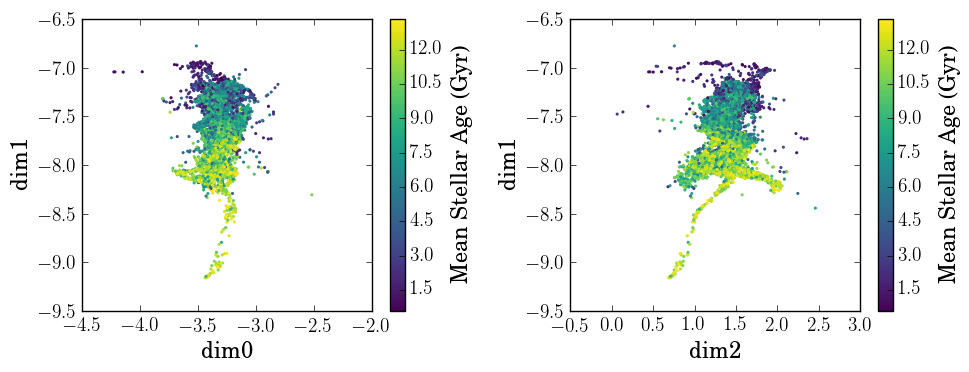

In [86]:
# plot some dimensions against each other color coded by a param of interest
wh = labels == 0
use_embed = embed[wh,:] * 1000
make_cc_plot(use_embed, mean_ages[:10000][wh], 'Mean Stellar Age (Gyr)', dims=[[0,1],[2,1]])

(<matplotlib.figure.Figure at 0x212095ad0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x21bbc2590>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x21c3bcb10>], dtype=object))

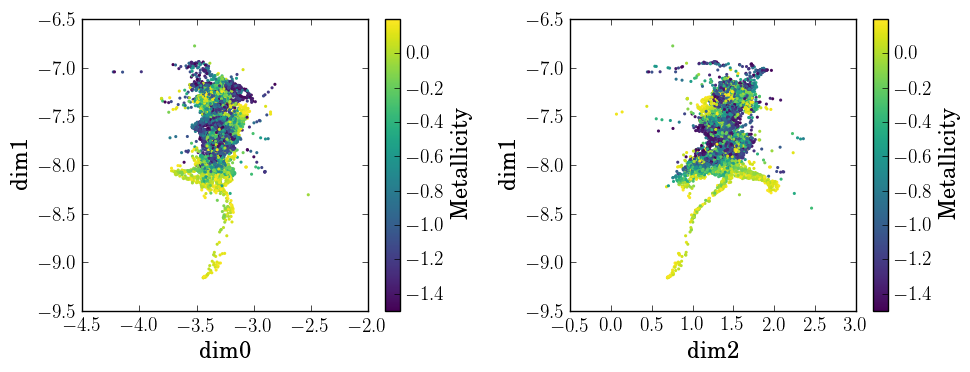

In [87]:
make_cc_plot(use_embed, zs[:10000][wh], 'Metallicity', dims=[[0,1],[2,1]])

(<matplotlib.figure.Figure at 0x21bbb8490>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x21c5cd550>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x21c9cd390>], dtype=object))

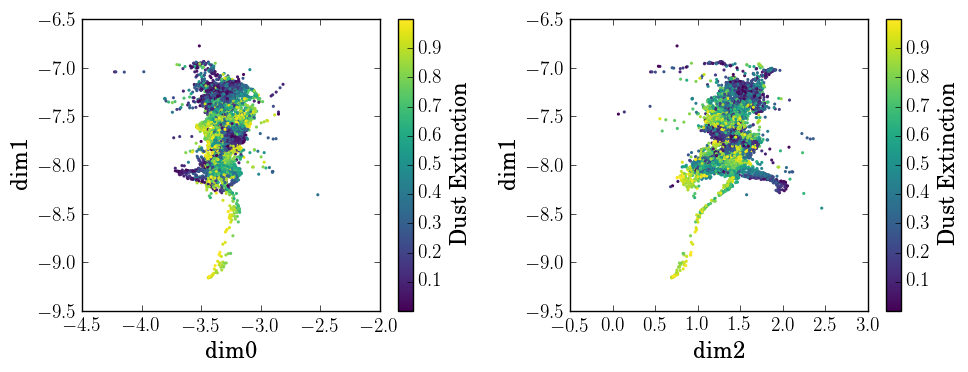

In [88]:
make_cc_plot(use_embed, dusts[:10000][wh], 'Dust Extinction', dims=[[0,1],[2,1]])

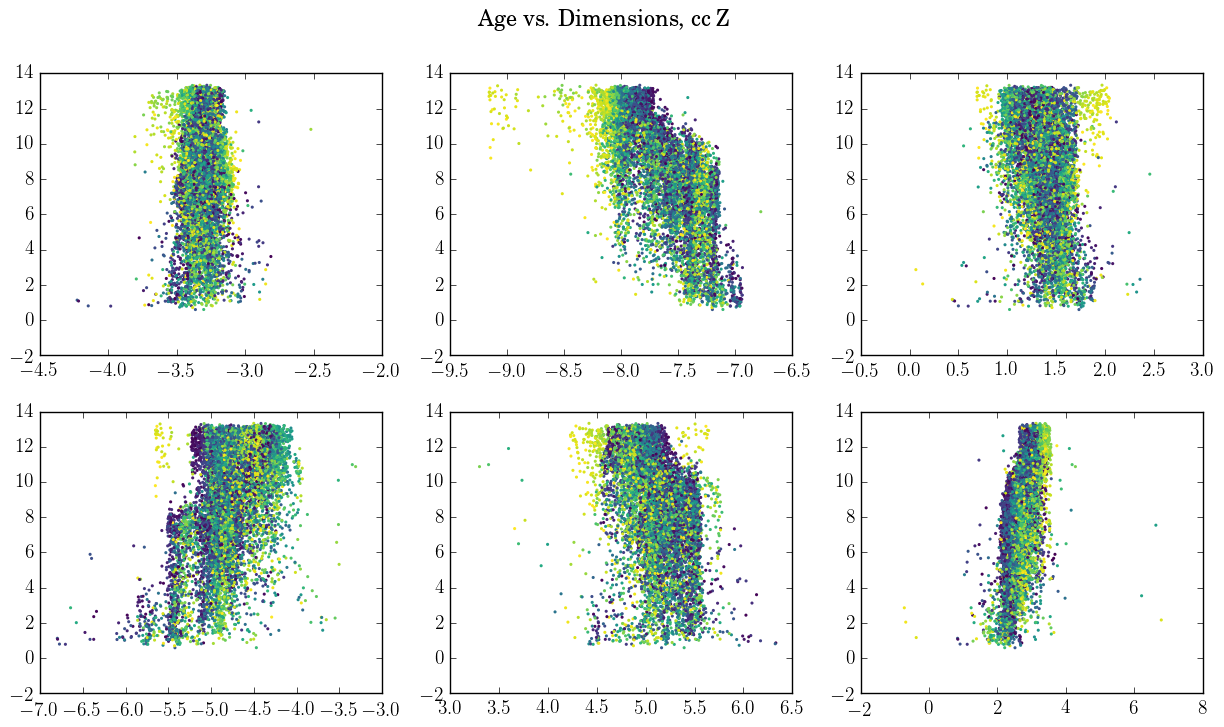

In [94]:
# plot all of the parameters of interest vs. all dimensions in the embedding, color-code by other params... 
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], mean_ages[:10000][wh], c=zs[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Age vs. Dimensions, cc Z')

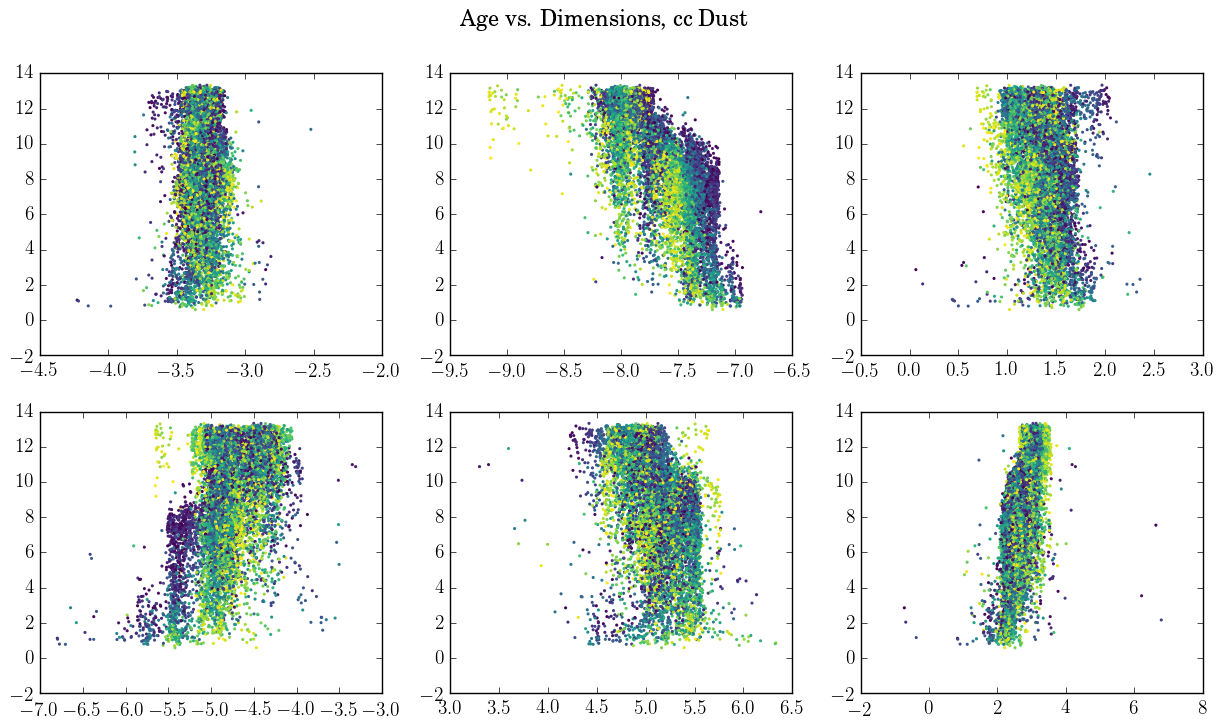

In [95]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], mean_ages[:10000][wh], c=dusts[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Age vs. Dimensions, cc Dust')

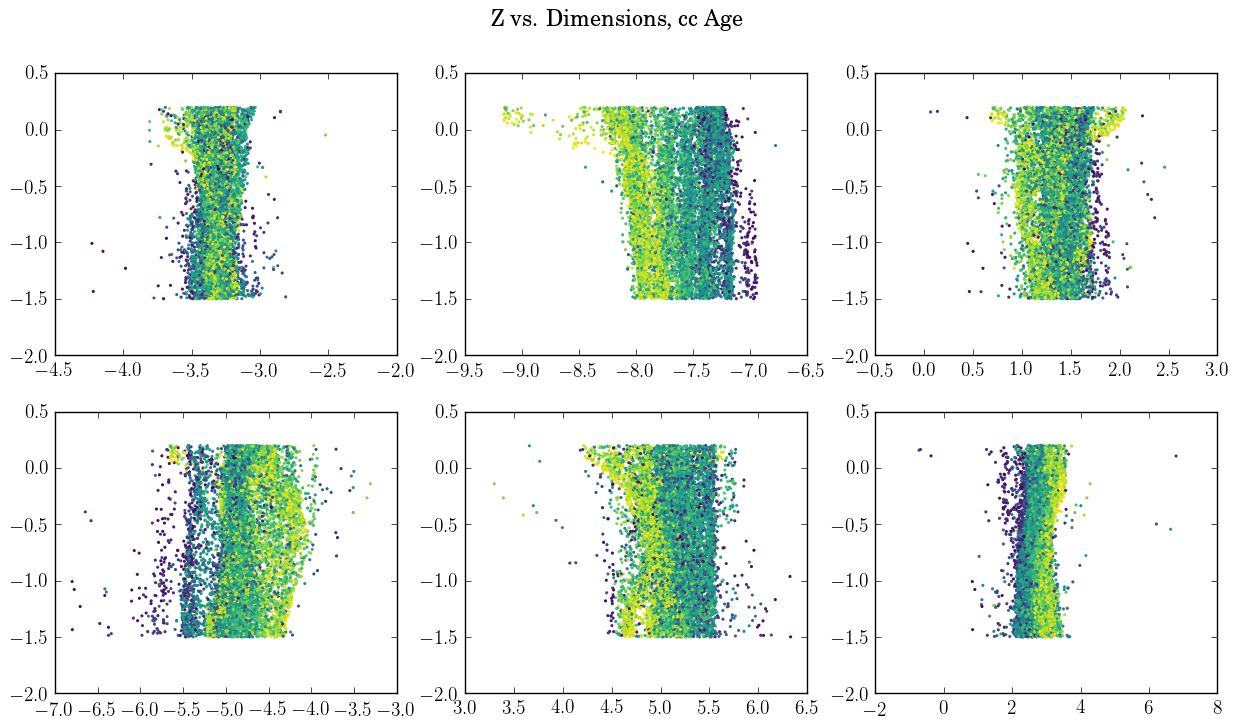

In [97]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], zs[:10000][wh], c=mean_ages[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Z vs. Dimensions, cc Age')

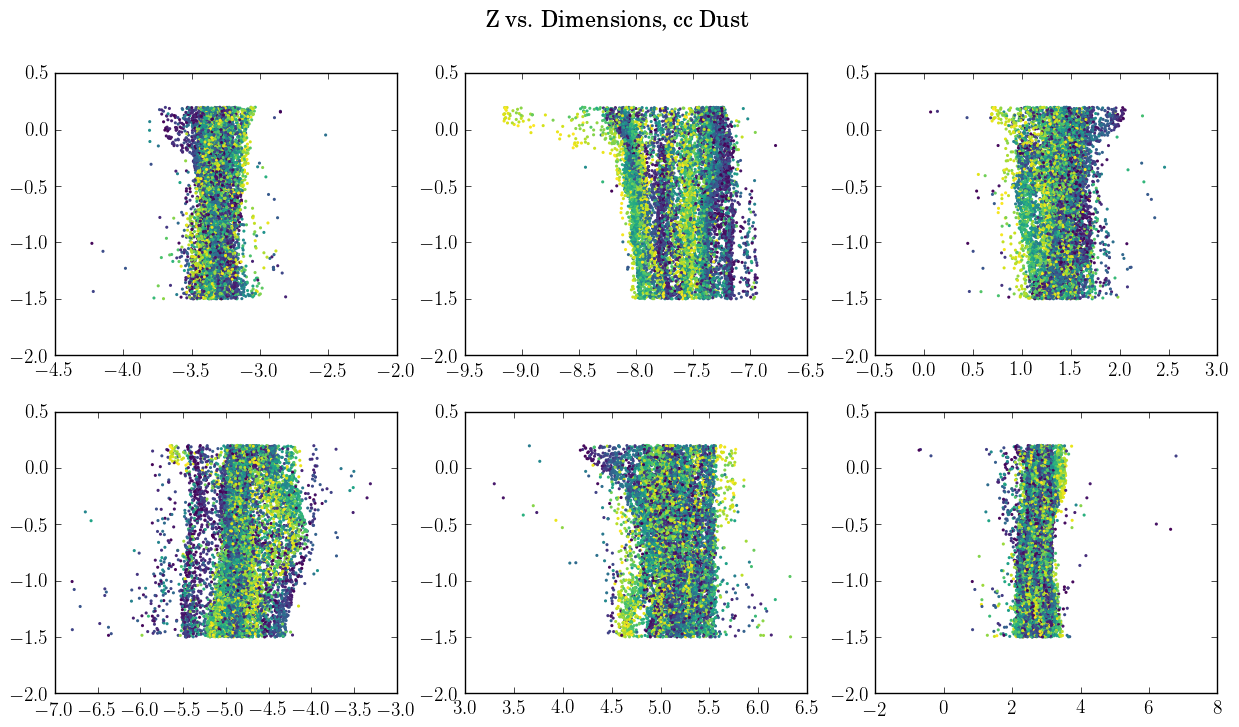

In [98]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], zs[:10000][wh], c=dusts[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Z vs. Dimensions, cc Dust')

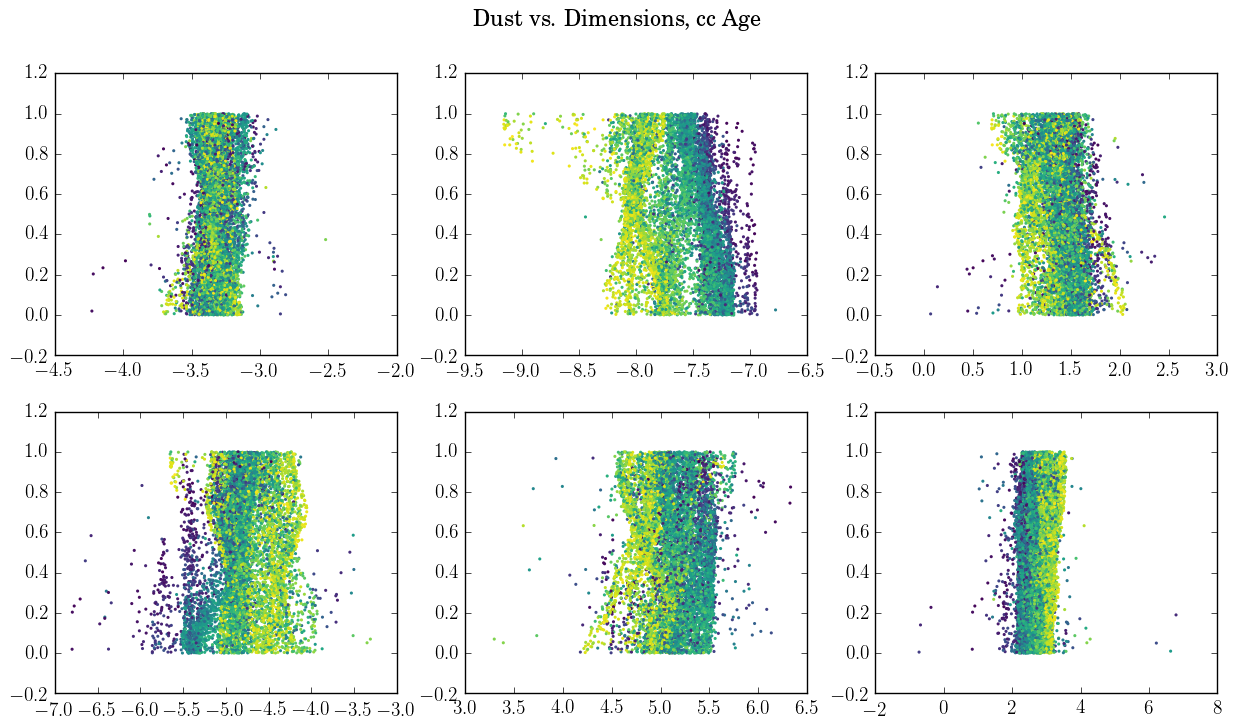

In [99]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], dusts[:10000][wh], c=mean_ages[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Dust vs. Dimensions, cc Age')

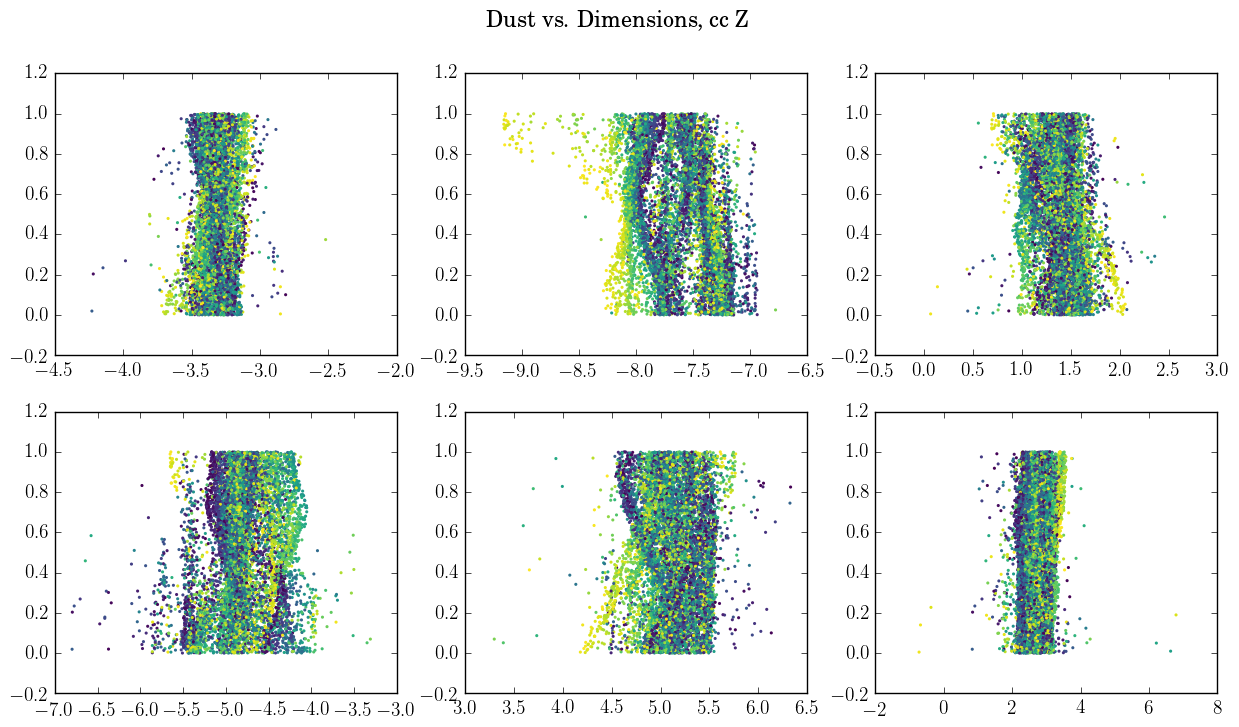

In [100]:
# plot the dimensions in embedding vs. a parameter of interest
ndim = 6
fig, ax = plt.subplots(2, ndim/2, figsize=(15,8))
ax = ax.ravel()
for ii in range(ndim):
    ax[ii].scatter(use_embed[:,ii], dusts[:10000][wh], c=zs[:10000][wh], s=5, lw=0, cmap='viridis')
fig.suptitle('Dust vs. Dimensions, cc Z')